# Croston's Method

## Imports

In [151]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
from sklearn.metrics import mean_absolute_error
from statsforecast import StatsForecast
from statsforecast.models import CrostonClassic
from statsforecast.models import CrostonOptimized
from statsforecast.models import ADIDA
from statsforecast.models import SimpleExponentialSmoothingOptimized as SESOpt
from statsforecast.models import IMAPA
import numpy as np
from statsforecast.models import TSB

In [114]:
from datetime import datetime

In [115]:
ROUND_PREDICTIONS = False
SAVE_MODEL_TO_DISK = False
SAVE_DICT_TO_DISK = True
CURRENT_DATE = datetime.now().strftime("%d%m%Y_%H%M")
print("CURRENT_DATE", CURRENT_DATE)

CURRENT_DATE 29112024_1517


## Data

In [116]:
base_path = '..\\data\\top_10_crimes\\'

In [117]:
dist_ids = os.listdir(base_path)
dist_ids

['1.0', '2.0', '3.0', '4.0', '5.0', '6.0']

In [118]:
cluster_names = os.listdir(os.path.join(base_path, dist_ids[0]))
print("num_cluster_names", len(cluster_names))

num_cluster_names 10


In [119]:
def load_crime_data(dist_id, offense, subset="train"):
    data_path = f"../data/top_10_crimes/{dist_id}/{offense}/{subset}.csv"
    crime_df = pd.read_csv(data_path, parse_dates=[0], index_col=0)
    return crime_df

In [120]:
crime_dist_dfs = {}
for i, dist_id in enumerate(dist_ids):
    crime_dist_dfs[dist_id] = {}
    for i, cluster_name in enumerate(cluster_names):
        train = load_crime_data(dist_id, cluster_name, subset="train")
        test = load_crime_data(dist_id, cluster_name, subset="test")
        
        # Save final dict
        crime_dist_dfs[dist_id][cluster_name] = {
            "train": train,
            "test": test
        }

In [121]:
print(f"districts in dict: {crime_dist_dfs.keys()}")
print(f"crimes in dict: {crime_dist_dfs["1.0"].keys()}")
print(f"test/train in dict: {crime_dist_dfs["1.0"]['Auto Theft'].keys()}")

districts in dict: dict_keys(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0'])
crimes in dict: dict_keys(['Aggravated Assault', 'Assault', 'Auto Theft', 'Burglary', 'Domestic Assault', 'Domestic Violence', 'Property Damage', 'Sexual Assault', 'Shoplifting', 'Stolen Auto'])
test/train in dict: dict_keys(['train', 'test'])


In [122]:
crime_dist_dfs["1.0"]['Auto Theft']["train"].head()

,Crime_Count
Reported_Date,
2015-01-01,4
2015-01-02,0
2015-01-03,2
2015-01-04,2
2015-01-05,6


> Reformat data

In [123]:
# Function to restructure the data
def restructure_for_forecasting(crime_dict):
    unique_id = 1
    for dist_id, crime_data in crime_dict.items():
        for cluster_name, df_types in crime_data.items():
            for df_type, df in df_types.items():
                # Reset index to make Reported_Date a column
                df = df.reset_index(names="Reported_Date")
                # Add unique_id column
                df['unique_id'] = unique_id
                # Rename columns
                df = df.rename(columns={"Reported_Date": "ds", "Crime_Count": "y"})
                # Ensure the date column is in datetime format
                df['ds'] = pd.to_datetime(df['ds'])
                # Reassign the processed dataframe back
                crime_dist_dfs[dist_id][cluster_name][df_type] = df
                unique_id+=1

# Apply the function
restructure_for_forecasting(crime_dist_dfs)

In [124]:
crime_dist_dfs["1.0"]['Auto Theft']["train"].tail(10)

,ds,y,unique_id
3274,2023-12-19,1,5
3275,2023-12-20,1,5
3276,2023-12-21,0,5
3277,2023-12-22,2,5
3278,2023-12-23,2,5
3279,2023-12-24,0,5
3280,2023-12-25,0,5
3281,2023-12-26,0,5
3282,2023-12-27,1,5
3283,2023-12-28,2,5


## Start forecasting

### Classic

In [125]:
df_train = crime_dist_dfs["1.0"]['Auto Theft']["train"]
df_test = crime_dist_dfs["1.0"]['Auto Theft']["test"]

In [126]:
models = [CrostonClassic()]

sf = StatsForecast(models=models, freq='D', n_jobs=-1)
            
sf.fit(df=df_train)

StatsForecast(models=[CrostonClassic])

In [127]:
cv_df = sf.cross_validation(
    df=df_train,
    h=1,
    step_size=1,
    n_windows=50
)

In [128]:
cv_df.index = np.arange(50, 100, 1)

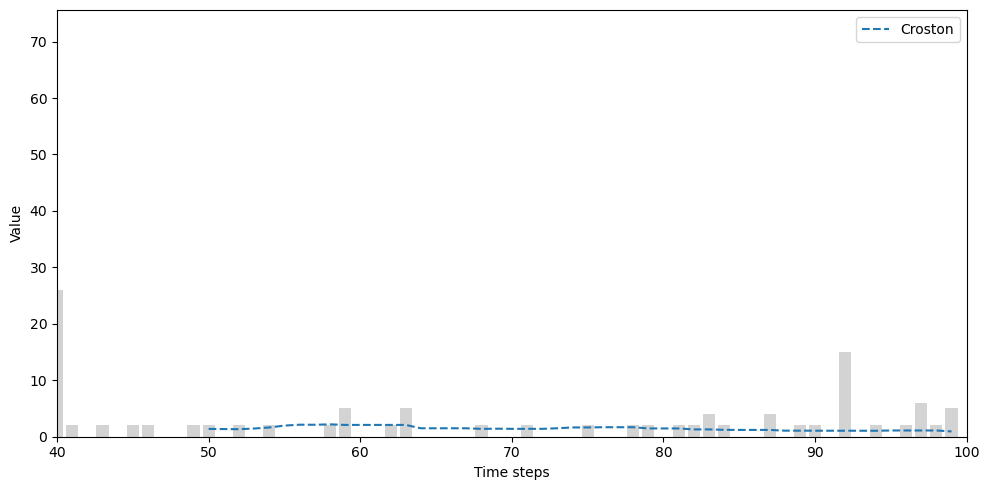

In [129]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(df_train.index, df_train['y'], color='lightgray')
ax.plot(cv_df.index, cv_df['CrostonClassic'], ls='--', label='Croston')
ax.set_ylabel('Value')
ax.set_xlabel('Time steps')
ax.legend(loc='best')
plt.xlim(40, 100)

plt.tight_layout()

### Optimized

In [130]:
models = [CrostonOptimized()]

sf = StatsForecast(models=models, freq='D', n_jobs=-1)
            
sf.fit(df=df_train)

StatsForecast(models=[CrostonOptimized])

In [131]:
cv_df = sf.cross_validation(
    df=df_train,
    h=1,
    step_size=1,
    n_windows=50
)

In [132]:
cv_df.index = np.arange(50, 100, 1)

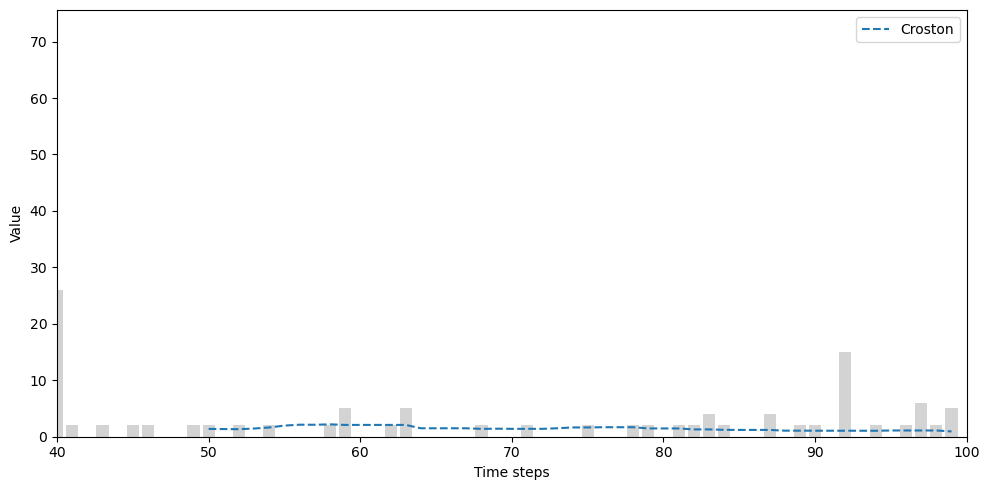

In [133]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(df_train.index, df_train['y'], color='lightgray')
ax.plot(cv_df.index, cv_df['CrostonOptimized'], ls='--', label='Croston')
ax.set_ylabel('Value')
ax.set_xlabel('Time steps')
ax.legend(loc='best')
plt.xlim(40, 100)

plt.tight_layout()

### ADIDA

In [134]:
models = [CrostonOptimized(), ADIDA()]

sf = StatsForecast(models=models, freq='D', n_jobs=-1)
            
sf.fit(df=df_train)

StatsForecast(models=[CrostonOptimized,ADIDA])

In [135]:
cv_df = sf.cross_validation(
    df=df_train,
    h=1,
    step_size=1,
    n_windows=50
)

In [136]:
cv_df.index = np.arange(50, 100, 1)

In [137]:
cv_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 50 to 99
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   unique_id         50 non-null     int64         
 1   ds                50 non-null     datetime64[ns]
 2   cutoff            50 non-null     datetime64[ns]
 3   y                 50 non-null     float32       
 4   CrostonOptimized  50 non-null     float32       
 5   ADIDA             50 non-null     float32       
dtypes: datetime64[ns](2), float32(3), int64(1)
memory usage: 2.0 KB


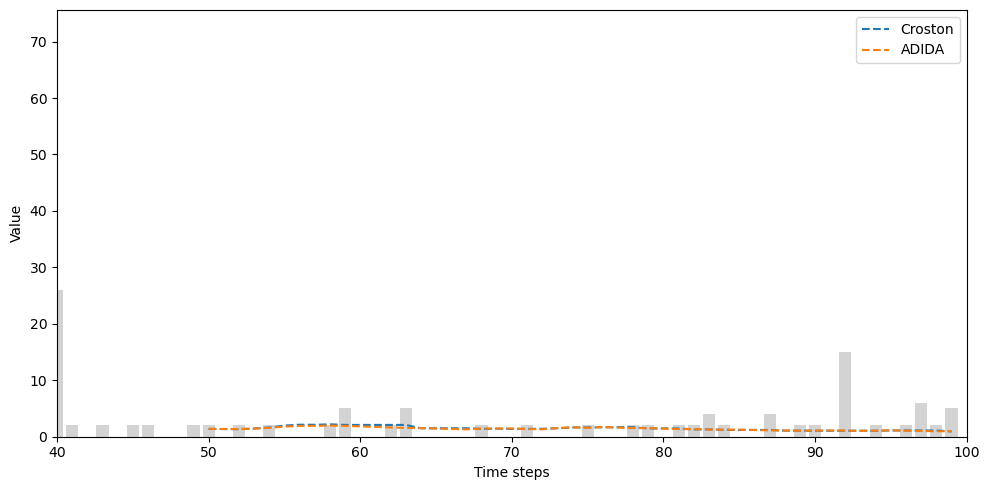

In [138]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(df_train.index, df_train['y'], color='lightgray')
ax.plot(cv_df.index, cv_df['CrostonOptimized'], ls='--', label='Croston')
ax.plot(cv_df.index, cv_df['ADIDA'], ls='--', label='ADIDA')
ax.set_ylabel('Value')
ax.set_xlabel('Time steps')
ax.legend(loc='best')
plt.xlim(40, 100)

plt.tight_layout()

### Multiple models

In [139]:
models = [CrostonOptimized(), ADIDA(), IMAPA(), TSB(0.2, 0.2), SESOpt()]

sf = StatsForecast(models=models, freq='D', n_jobs=-1)
            
sf.fit(df=df_train)

StatsForecast(models=[CrostonOptimized,ADIDA,IMAPA,TSB,SESOpt])

In [140]:
d_cv_df = sf.cross_validation(
    df=df_train,
    h=1, # Horizon is 1, since we forecast the next day
    step_size=1, # Move the window by 1 time step
    n_windows=50 # Make 50 windows of cross-validation
)

In [146]:
d_cv_df.head()

,unique_id,ds,cutoff,y,CrostonOptimized,ADIDA,IMAPA,TSB,SESOpt
0,5,2023-11-09,2023-11-08,1.0,1.383824,1.399418,1.392615,1.411414,1.375582
1,5,2023-11-10,2023-11-09,1.0,1.357999,1.373117,1.360174,1.372985,1.363504
2,5,2023-11-11,2023-11-10,3.0,1.333097,1.359476,1.335992,1.326454,1.351817
3,5,2023-11-12,2023-11-11,4.0,1.452685,1.435806,1.458532,1.621168,1.404811
4,5,2023-11-13,2023-11-12,6.0,1.640751,1.573529,1.653330,2.048153,1.488328


In [147]:
d_cv_df.index

RangeIndex(start=0, stop=50, step=1)

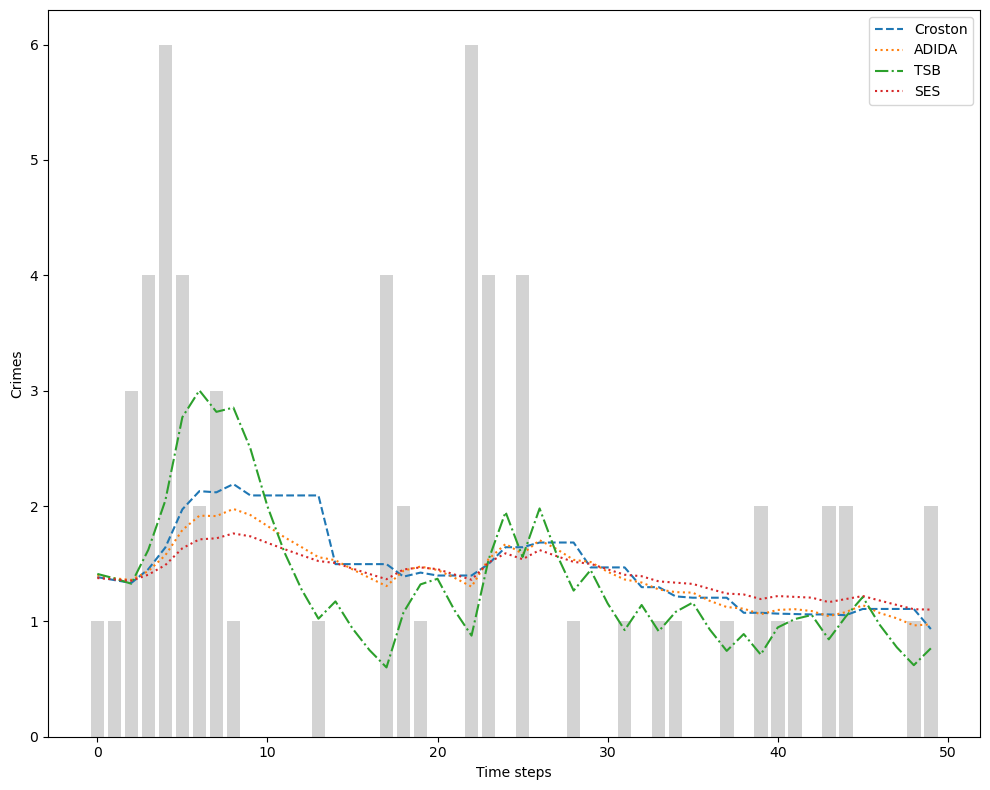

In [148]:
fig, ax = plt.subplots( figsize=(10,8))

ax.bar(d_cv_df.index, d_cv_df['y'], color='lightgrey')
ax.plot(d_cv_df.index, d_cv_df['CrostonOptimized'], ls='--', label='Croston')
ax.plot(d_cv_df.index, d_cv_df['ADIDA'], ls=':', label='ADIDA')
ax.plot(d_cv_df.index, d_cv_df['TSB'], ls='-.', label='TSB')
ax.plot(d_cv_df.index, d_cv_df['SESOpt'], ls=':', label='SES')

ax.set_ylabel('Crimes')
ax.set_xlabel('Time steps')

ax.legend(loc='best')

plt.tight_layout()

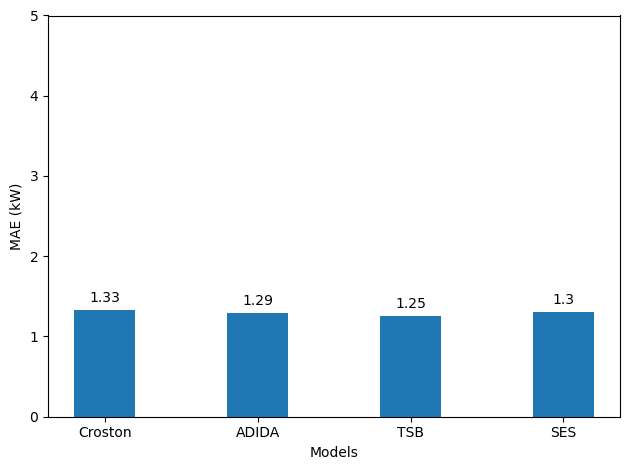

In [154]:
mae_croston_h = mean_absolute_error(d_cv_df['y'], d_cv_df['CrostonOptimized'])
mae_adida_h = mean_absolute_error(d_cv_df['y'], d_cv_df['ADIDA'])
mae_tsb_h = mean_absolute_error(d_cv_df['y'], d_cv_df['TSB'])
mae_ses_h = mean_absolute_error(d_cv_df['y'], d_cv_df['SESOpt'])

y = [mae_croston_h, mae_adida_h, mae_tsb_h, mae_ses_h]
x = ['Croston', 'ADIDA', 'TSB', 'SES']

fig, ax = plt.subplots()

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE (kW)')
ax.set_xlabel('Models')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')
    
plt.tight_layout()

In [155]:
w_cv_df = sf.cross_validation(
    df=df_train,
    h=7,
    step_size=7,
    n_windows=5
)

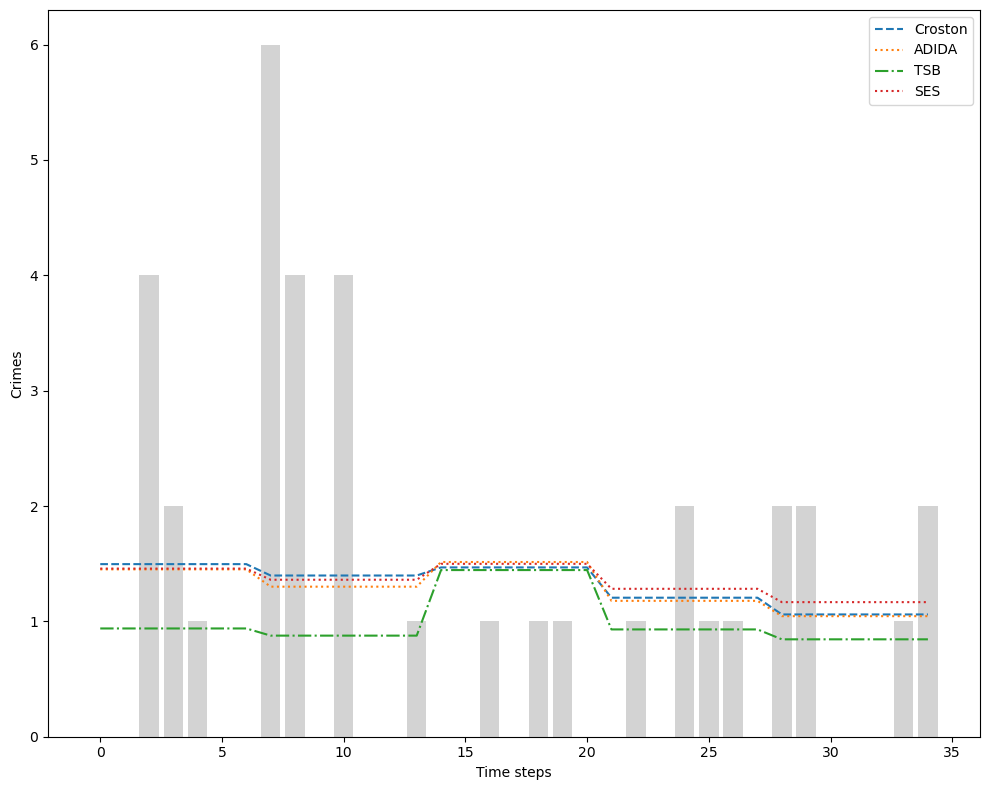

In [156]:
fig, ax = plt.subplots( figsize=(10,8))

ax.bar(w_cv_df.index, w_cv_df['y'], color='lightgrey')
ax.plot(w_cv_df.index, w_cv_df['CrostonOptimized'], ls='--', label='Croston')
ax.plot(w_cv_df.index, w_cv_df['ADIDA'], ls=':', label='ADIDA')
ax.plot(w_cv_df.index, w_cv_df['TSB'], ls='-.', label='TSB')
ax.plot(w_cv_df.index, w_cv_df['SESOpt'], ls=':', label='SES')

ax.set_ylabel('Crimes')
ax.set_xlabel('Time steps')

ax.legend(loc='best')

plt.tight_layout()

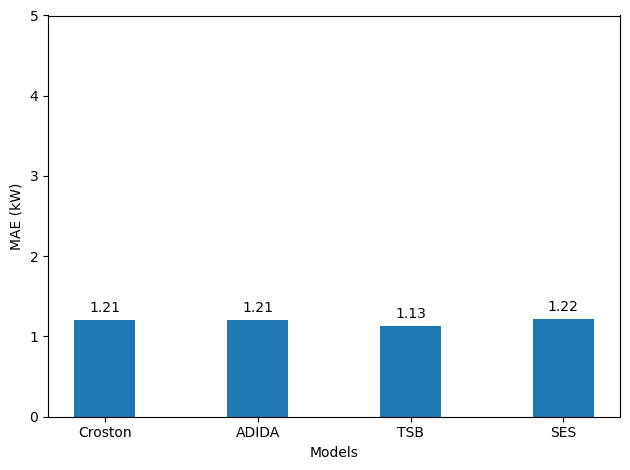

In [157]:
mae_croston_h = mean_absolute_error(w_cv_df['y'], w_cv_df['CrostonOptimized'])
mae_adida_h = mean_absolute_error(w_cv_df['y'], w_cv_df['ADIDA'])
mae_tsb_h = mean_absolute_error(w_cv_df['y'], w_cv_df['TSB'])
mae_ses_h = mean_absolute_error(w_cv_df['y'], w_cv_df['SESOpt'])

y = [mae_croston_h, mae_adida_h, mae_tsb_h, mae_ses_h]
x = ['Croston', 'ADIDA', 'TSB', 'SES']

fig, ax = plt.subplots()

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE (kW)')
ax.set_xlabel('Models')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')
    
plt.tight_layout()

### Plot vs test

In [185]:
n_days = len(df_test)-1

In [186]:
d_cv_df = sf.cross_validation(
    df=df_test,
    h=1, # Horizon is 1, since we forecast the next day
    step_size=1, # Move the window by 1 time step
    n_windows=n_days
)

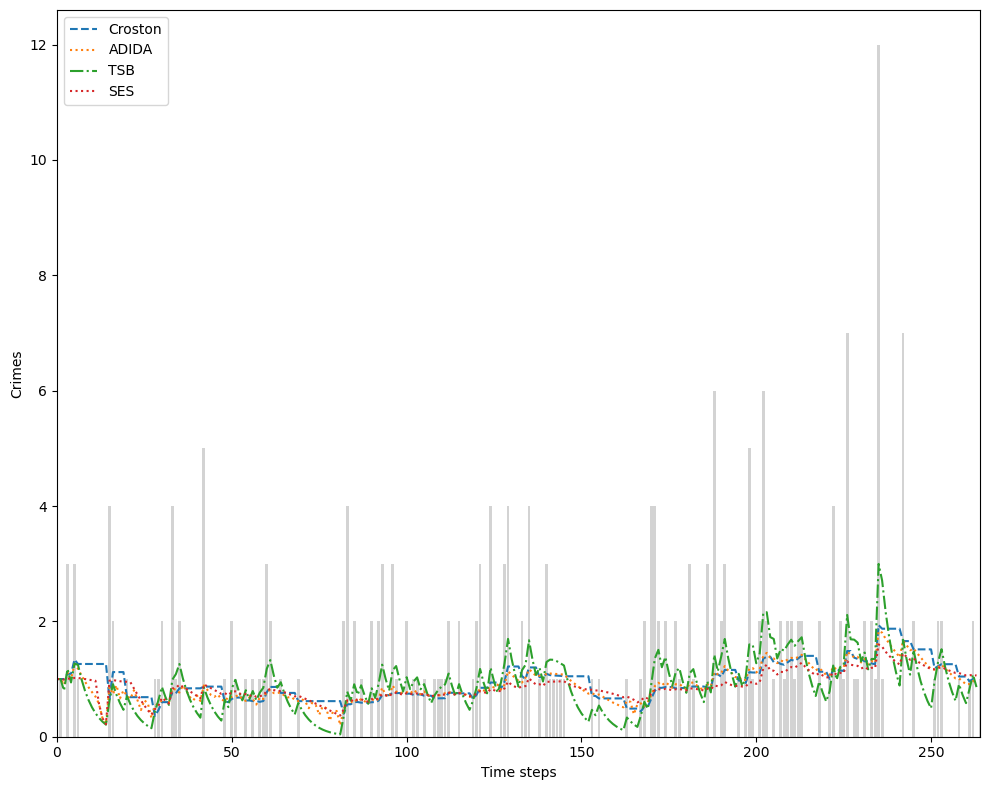

In [187]:
fig, ax = plt.subplots(figsize=(10,8))

ax.bar(df_test.index, df_test['y'], color='lightgrey')
ax.plot(d_cv_df.index, d_cv_df['CrostonOptimized'], ls='--', label='Croston')
ax.plot(d_cv_df.index, d_cv_df['ADIDA'], ls=':', label='ADIDA')
ax.plot(d_cv_df.index, d_cv_df['TSB'], ls='-.', label='TSB')
ax.plot(d_cv_df.index, d_cv_df['SESOpt'], ls=':', label='SES')

ax.set_ylabel('Crimes')
ax.set_xlabel('Time steps')

ax.legend(loc='best')

plt.xlim([0,n_days])

plt.tight_layout()

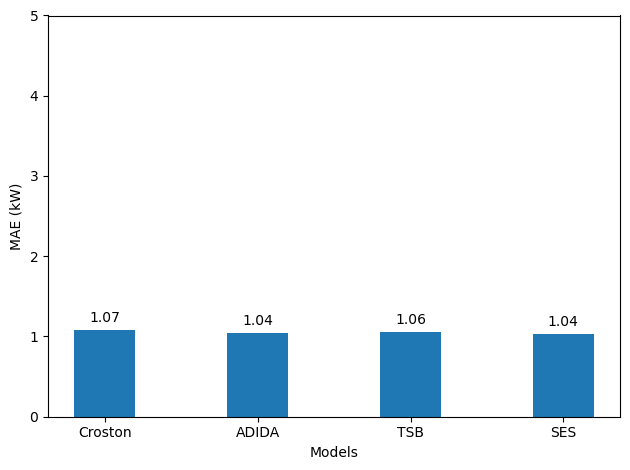

In [188]:
mae_croston_h = mean_absolute_error(d_cv_df['y'], d_cv_df['CrostonOptimized'])
mae_adida_h = mean_absolute_error(d_cv_df['y'], d_cv_df['ADIDA'])
mae_tsb_h = mean_absolute_error(d_cv_df['y'], d_cv_df['TSB'])
mae_ses_h = mean_absolute_error(d_cv_df['y'], d_cv_df['SESOpt'])

y = [mae_croston_h, mae_adida_h, mae_tsb_h, mae_ses_h]
x = ['Croston', 'ADIDA', 'TSB', 'SES']

fig, ax = plt.subplots()

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE (kW)')
ax.set_xlabel('Models')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')
    
plt.tight_layout()

---